In [43]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Dropout
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# خواندن داده‌ها
data = pd.read_csv("Car.csv")

# کدگذاری ستون‌های دسته‌بندی
categorical_columns = ['fueltype', 'aspiration', 'CarName','doornumber','carbody','drivewheel','enginelocation','fuelsystem','cylindernumber','enginetype']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

tensor_data = tf.constant(data, dtype=tf.float32)
tensor_data = tf.random.shuffle(tensor_data)

X = tensor_data[:, 3:-1]
y = tf.expand_dims(tensor_data[:, -1], axis=-1)

# نرمال‌سازی داده‌ها
normalizer = Normalization()
normalizer.adapt(X)

# تعریف تابع برای ایجاد مدل
def create_model():
    model = tf.keras.Sequential([
        InputLayer(input_shape=(22,)),
        normalizer,
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(8, activation="relu"),
        Dense(4, activation="relu"),
        Dense(2, activation="relu"),
        Dense(1),
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanAbsoluteError(),
                  metrics=[RootMeanSquaredError()])
    return model

# اجرای K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train_index, val_index in kfold.split(X):
    print(f'Fold {fold_no}')

    X_train, X_val = tf.gather(X, train_index), tf.gather(X, val_index)
    y_train, y_val = tf.gather(y, train_index), tf.gather(y, val_index)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1500).batch(64).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.shuffle(buffer_size=1500).batch(64).prefetch(tf.data.AUTOTUNE)

    model = create_model()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=400, verbose=1, callbacks=[early_stop])

    fold_no += 1



Fold 1
Epoch 1/400
3/3 [==============================] - 2s 75ms/step - loss: 13392.0195 - root_mean_squared_error: 15694.4229 - val_loss: 12815.4346 - val_root_mean_squared_error: 14616.6230
Epoch 2/400
3/3 [==============================] - 0s 13ms/step - loss: 13392.0020 - root_mean_squared_error: 15694.4014 - val_loss: 12815.4053 - val_root_mean_squared_error: 14616.5908
Epoch 3/400
3/3 [==============================] - 0s 21ms/step - loss: 13391.9756 - root_mean_squared_error: 15694.3711 - val_loss: 12815.3633 - val_root_mean_squared_error: 14616.5459
Epoch 4/400
3/3 [==============================] - 0s 21ms/step - loss: 13391.9297 - root_mean_squared_error: 15694.3223 - val_loss: 12815.3076 - val_root_mean_squared_error: 14616.4873
Epoch 5/400
3/3 [==============================] - 0s 13ms/step - loss: 13391.8672 - root_mean_squared_error: 15694.2607 - val_loss: 12815.2383 - val_root_mean_squared_error: 14616.4131
Epoch 6/400
3/3 [==============================] - 0s 13ms/step

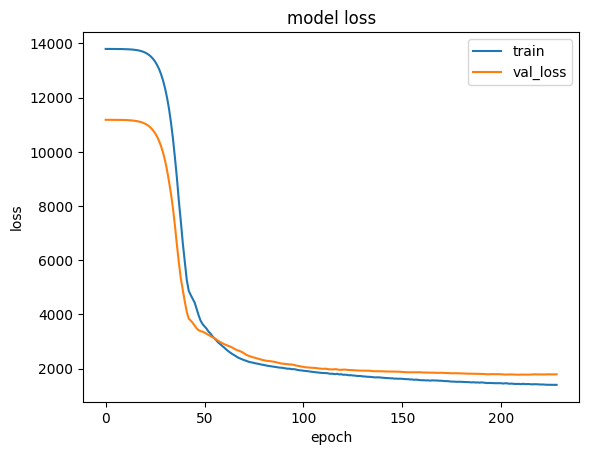

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

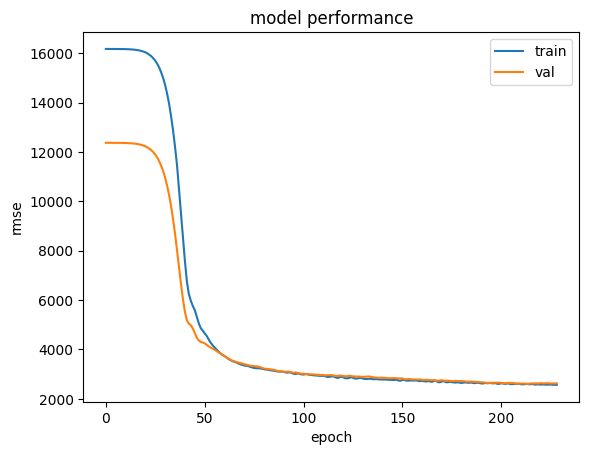

In [45]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [46]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 23ms/step - loss: 970.1138 - root_mean_squared_error: 1581.0446


[970.1138305664062, 1581.0445556640625]

In [47]:
model.predict(tf.expand_dims(X_test[0], axis = 0 ))

1/1 [==============================] - 0s 82ms/step


array([[18538.59]], dtype=float32)

In [48]:
y_test[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([19699.], dtype=float32)>

In [49]:
y_true = list(y_test[:,0].numpy())

In [50]:
y_pred = list(model.predict(X_test)[:,0])
print(y_pred)

1/1 [==============================] - 0s 18ms/step
[18538.59, 12882.365, 16275.75, 6191.633, 16179.434, 9846.249, 8179.9136, 5463.761, 7401.149, 6924.9478, 35910.227, 8918.561, 6706.494, 12959.362, 34022.73, 7419.358, 6323.5737, 7271.7812, 5789.951, 7111.453, 8221.787]


1/1 [==============================] - 0s 18ms/step


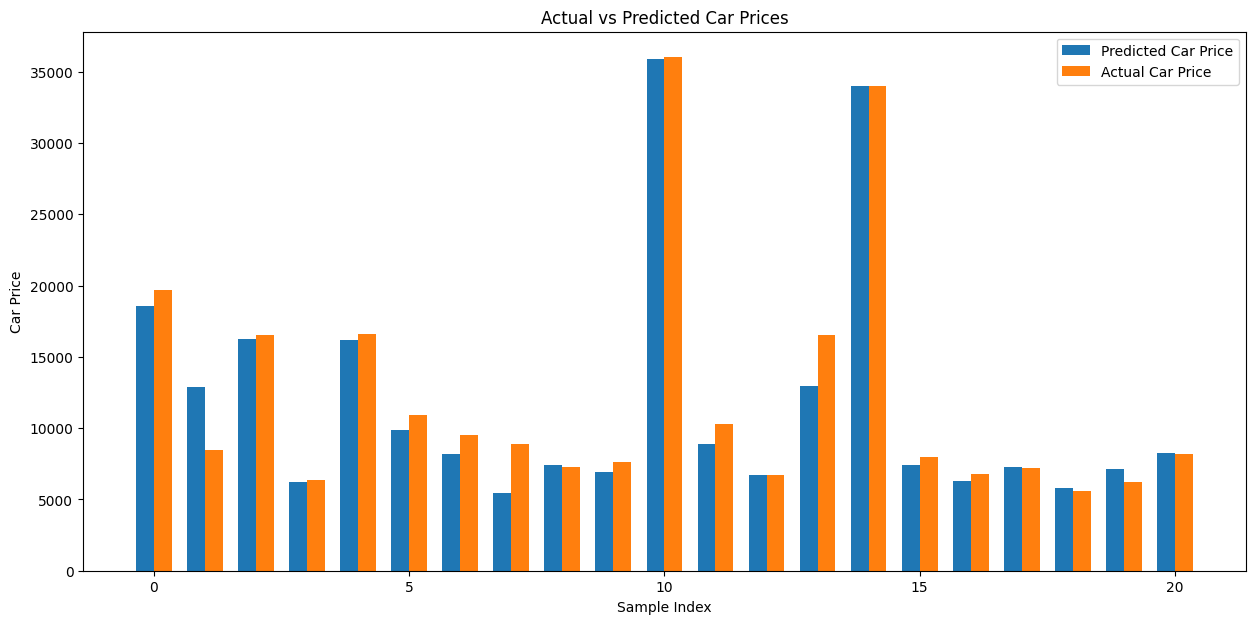

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to lists for easier handling
y_true = list(y_test[:,0].numpy())
y_pred = list(model.predict(X_test)[:,0])

# Ensure that the lengths of y_true and y_pred are the same
assert len(y_true) == len(y_pred), "Length of y_true and y_pred must be the same"

# Define the number of elements for x-axis indices
ind = np.arange(len(y_true))

# Plotting
plt.figure(figsize=(15, 7))  # Adjust size as needed
width = 0.35  # Adjust width to fit bars nicely

plt.bar(ind - width/2, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width/2, y_true, width, label='Actual Car Price')

plt.xlabel('Sample Index')
plt.ylabel('Car Price')
plt.title('Actual vs Predicted Car Prices')
plt.legend()
plt.show()

In [52]:
model.save('rez_very_true.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
